In [283]:
#from supportFunctions import *
import cPickle as pickle
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

import matplotlib.pyplot as plt
import numpy
import scipy.cluster.hierarchy as hcluster




In [284]:
def extractFeatures(imageDict, dist = 4):
    n = imageDict['numPointsInBox']
    y = np.zeros(n)
    
    v1,v2,h1,h2 = imageDict['boxEdges']
    
    img = imageDict['image1bit']
    featuresList = []
    
    fingerSet = imageDict['allFingerPoints']

    c = 0 
    for i in range(h1,h2):
        for j in range(v1,v2):
            x_matrix  = img[i-dist-1:i+dist , j-dist-1: j+dist]
            xVec = x_matrix.ravel()
            featuresList.append(xVec)
            
            if max(np.sum([i , j] == fingerSet, axis = 1 )) == 2:
                y[c] = 1
            
            c = c + 1

    X = np.vstack((featuresList))
    return(X,y)
    

In [285]:
def extractExamplesFromList(imageList, dist = 4):
    allFeaturesList = []
    allTargetList = []

    for i, imageDict in enumerate(imageList):
        features, target = extractFeatures(imageDict, dist = dist)
        allFeaturesList.append(features)
        allTargetList.append(target)

    x = np.vstack((allFeaturesList))
    y = np.hstack((allTargetList))
    
    return x, y

In [337]:
def Reshape_to_yHatMatrix(testingExamples, yHat):
    number_of_images = len(testingExamples)
    
    image_sizes = []
    result = []
    c = 0 
    for i in range(number_of_images):
        dummy_idx = (testingExamples[i]['boxHeight'],testingExamples[i]['boxWidth'])
        image_sizes.append(dummy_idx)
        
        test_im = yHat[c:(c + dummy_idx[0]*dummy_idx[1])] 
        c = c + (dummy_idx[0] * dummy_idx[1])
        
        test_im_matrix = test_im.reshape((dummy_idx[0], dummy_idx[1]))
        result.append(test_im_matrix)
    
    return(result)

In [338]:
def remove_small_clusters(clusters, min_finger_pixel):
    unique = set(clusters)
    for c in unique:
        if sum(clusters == c) < min_finger_pixel:
            clusters = np.delete(clusters, np.where(clusters == c))
    return(clusters)

In [339]:
pickleFileName = 'fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

In [340]:
#Constructing Traning Data Set:
trainingExampleIndices = np.arange(0,39)
trainingExamples = [data[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, dist = 4)

#Constructing Test Data Set:
testingExampleIndices = [50, 51, 52]
testingExamples = [data[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, dist = 4)


In [341]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)
clf = clf.fit(trainX, trainY)
yHat = clf.predict(testX)

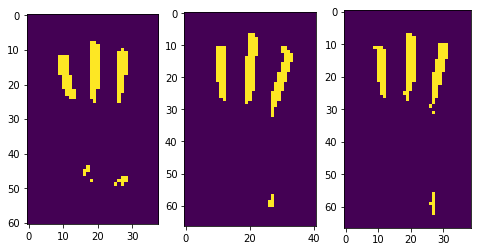

In [342]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

In [292]:
X_i = np.where(Y_hat[1] == 1)[0]
X_j = np.where(Y_hat[1] == 1)[1]

data  = np.column_stack((X_i, X_j))
data.shape

(132, 2)

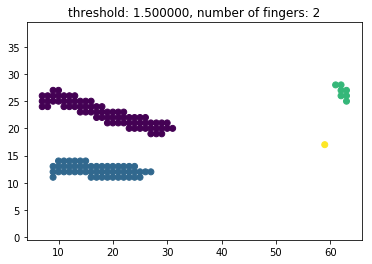

In [293]:
# clustering
thresh = 1.5
clusters = hcluster.fclusterdata(data, thresh, criterion="distance")
#removing small clusters (caused by false positives)
new_clusters = remove_small_clusters(clusters,15)

# plotting
plt.scatter(*numpy.transpose(data), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()
